### Student : Hussin Almoustafa
### Studentennummer : 1776495

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import math
import random
from itertools import permutations

## Pseudorandom number generator - Mersenne Twister 

![Wetstrijden tabel](1.png)


In [3]:
class Mersenne: 
    def __init__(self, seed):
        # Constanten voor het algoritme
        # W, N, M, en R zijn parameters van de Mersenne Twister.
        # A, U, D, S, B, T, C, L en F zijn coëfficiënten voor de Twister.
        self.W, self.N, self.M, self.R = 32, 624, 397, 31
        self.A, self.U, self.D, self.S, self.B, self.T, self.C, self.L, self.F = (
            0x9908B0DF, 11, 0xFFFFFFFF, 7, 0x9D2C5680, 15, 0xEFC60000, 18, 0x6C078965)


        # Initialiseren van de statusarray
        self.state = [seed] + [0] * (self.N - 1)
        self.index = self.N
        for i in range(1, self.N):
            # De array vullen met initiële waarden
            # Deze formule is: x_i = (f * (x_{i-1} xor (x_{i-1} >> (w-2))) + i) & d
            self.state[i] = self.F * (self.state[i - 1] ^ (self.state[i - 1] >> (self.W - 2))) + i & self.D

    def generate_numbers(self):
        for i in range(self.N):
            y = (self.state[i] & 0x80000000) + (self.state[(i + 1) % self.N] & 0x7FFFFFFF)
            self.state[i] = self.state[(i + self.M) % self.N] ^ (y >> 1)
            if y % 2 != 0:
                self.state[i] ^= self.A

    def random(self):
        # Een willekeurig getal genereren
        if self.index >= self.N:
            self.generate_numbers()
            self.index = 0

        y = self.state[self.index]
        self.index += 1

        # Temperen, om willekeur te verbeteren
        y ^= y >> self.U
        y ^= (y << self.S) & self.B
        y ^= (y << self.T) & self.C
        y ^= y >> self.L

        return y & self.D

    def randint(self, a, b):
        # Genereer een willekeurig geheel getal tussen a en b
        return a + int(self.random() / (2**self.W) * (b - a + 1))
        

# Testing de Mersenne Twister randomnness :

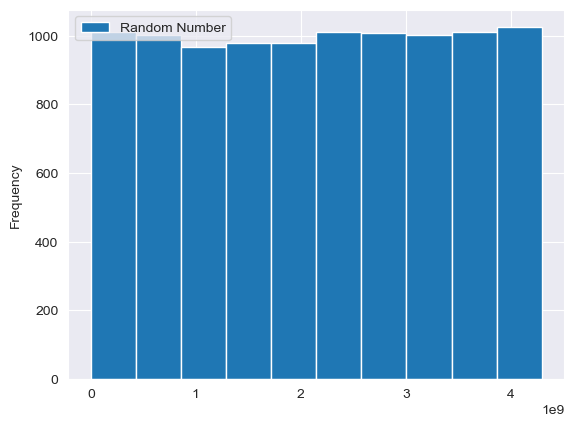

In [73]:
# Maak een exemplaar van de MT-klasse met zaad 5489
mersenne_twister = Mersenne(5489)

# Genereer 10 getallen met behulp van de tempering- (of willekeurige) methode

results = [mersenne_twister.random() for _ in range(10000)]
df = pd.DataFrame(results, columns=['Random Number']) #om de uniforme PRNG te kunnen ploten 

# Plot de resultaten using density plot om de uniformiteit te controleren
ax = df.plot(kind='hist')

plt.show()



## Opdracht deel 1
Maak een Monte Carlo Simulatie die meerdere keren (duizenden) de competitie speelt met gebruik van deze tabel van kansen. Hoe vaker je een competitie speelt, hoe nauwkeuriger je voorspelling wordt. Houd bij hoeveel punten elk team scoort in de competitie (3 punten voor winst, 1 punt voor gelijk, 0 voor verlies), en maak een overzicht (ranking) van de teams.

Gebruik je eigen geprogrammeerde Random Number Generator voor het uitvoeren van deze Monte Carlo Simulatie!

Maak een overzicht van de gemiddelden rank van de teams. D.w.z. bepaal je eindantwoord als een matrix, waarbij per team wordt aangegeven welke kans deze heeft om op die plek in het eindklassement te eindigen, op basis van de gesimuleerde spelletjes. Bijvoorbeeld (let op: deze tabel is gevuld met fictieve getallen!): 

![](2.png)
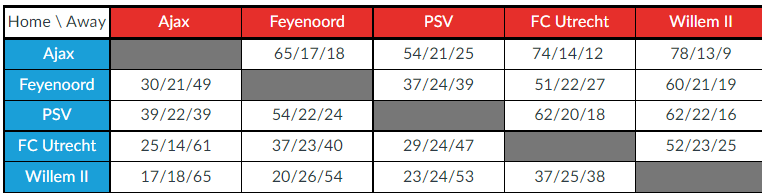

In [5]:
Ajax      =  [None, [65,17,18], [54,21,25], [74,14,12], [78,13,9]]
Feyenoord =  [[30,21,49], None, [37,24,39], [51,22,27], [60,21,19]]
PSV       =  [[39,22,39], [54,22,24], None, [62,20,18], [62,22,16]]
FCUtrecht =  [[25,14,61], [37,23,40], [29,24,47], None, [52,23,25]]
WillemII  =  [[17,18,65], [20,26,54], [23,24,53], [37,25,38], None]

In [40]:
teams = ["Ajax", "Feyenoord", "PSV", "FC Utrecht", "Willem II"]
team_df = pd.DataFrame([Ajax, Feyenoord, PSV, FCUtrecht, WillemII])
team_df = team_df.set_index(pd.Index(teams))
team_df.columns = teams

In [41]:
team_df

,Ajax,Feyenoord,PSV,FC Utrecht,Willem II
Ajax,None,"[65, 17, 18]","[54, 21, 25]","[74, 14, 12]","[78, 13, 9]"
Feyenoord,"[30, 21, 49]",None,"[37, 24, 39]","[51, 22, 27]","[60, 21, 19]"
PSV,"[39, 22, 39]","[54, 22, 24]",None,"[62, 20, 18]","[62, 22, 16]"
FC Utrecht,"[25, 14, 61]","[37, 23, 40]","[29, 24, 47]",None,"[52, 23, 25]"
Willem II,"[17, 18, 65]","[20, 26, 54]","[23, 24, 53]","[37, 25, 38]",None


## Simualtion : 

In [54]:
# Functie om één wedstrijd te simuleren
def wedstrijd_simuleren(data):
    """
    Simuleer één voetbalwedstrijd op basis van winstkansen.
    """
    if data is None:
        return None

    # Check if data needs to be split
    if isinstance(data, str):
        data = data.split('/')

    win, gelijk, verlies = map(int, data)

    rand = mersenne_twister.randint(1, 1000)

    if rand <= win:
        return 3  # Winst
    elif rand <= win + gelijk:
        return 1  # Gelijkspel
    else:
        return 0  # Verlies
# Functie om één competitie te simuleren
def competitie_simuleren():
    """
    Simuleer één voetbalcompetitie op basis van winstkansen.
    """
    wedstrijden = list(permutations(team_df.index, 2))
    punten_df = pd.DataFrame({'punten': np.zeros(len(team_df))}, index=team_df.index)

    for thuis, uit in wedstrijden:
        uitslag = wedstrijd_simuleren(team_df.loc[thuis, uit])
        punten_df.loc[thuis] += uitslag

        if uitslag == 3:
            punten_df.loc[uit] += 0
        elif uitslag == 1:
            punten_df.loc[uit] += 1
        else:
            punten_df.loc[uit] += 3

    return punten_df.sort_values(by='punten', ascending=False)

# Competitie simuleren en resultaat tonen
competitie_simuleren()

,punten
Ajax,12.0
Feyenoord,12.0
PSV,12.0
FC Utrecht,12.0
Willem II,12.0


In [66]:

def ranking(sim_results):
    """Helperfunctie om ranglijsten te berekenen op basis van simulatieresultaten"""
    rankings = sim_results['punten'].rank(ascending=False, method='min')
    return rankings.astype(int)

def monte_carlo(num_simulations , sim_function):
    teams = team_df.index
    num_teams = len(teams)
    ranking_counts = pd.DataFrame(0, index=teams, columns=range(1, num_teams+1))

    for _ in range(num_simulations):
        sim_results = sim_function()
        #print(sim_results)
        rankings = ranking(sim_results)
        #print(rankings)
        for team, rank in rankings.items():
            ranking_counts.at[team, rank] += 1

    ranking_probabilities = ranking_counts / num_simulations
    return ranking_probabilities

# Now run the Monte Carlo simulations
aantal_keren = 7000
ranking_prob = monte_carlo(aantal_keren, competitie_simuleren)

ranking_prob


,1,2,3,4,5
Ajax,0.497286,0.310143,0.060714,0.050000,0.081857
Feyenoord,0.437714,0.300857,0.064857,0.069857,0.126714
PSV,0.464286,0.304286,0.061000,0.066714,0.103714
FC Utrecht,0.400857,0.307000,0.069286,0.077571,0.145286
Willem II,0.374286,0.304429,0.069143,0.090000,0.162143


In de tabel is te zien dat elk team een verschillende kans heeft om op elke positie te eindigen, van de 1e tot de 5e plaats. Bijvoorbeeld, Ajax heeft ongeveer 50.9% kans om als eerste te eindigen, terwijl Willem II slechts ongeveer 37.7% kans heeft om dezelfde positie te behalen. Evenzo toont de laatste kolom de kans dat elk team als laatste eindigt. De som van de kansen in elke rij is gelijk aan 1 (of 100%), aangezien elk team precies één positie inneemt aan het einde van de competitie.

Deze kansen zijn berekend door het gemiddelde te nemen van de uitkomsten over 3000 gesimuleerde competities. De nauwkeurigheid van deze kansen neemt toe met het aantal simulaties dat wordt uitgevoerd, waardoor de voorspelling betrouwbaarder wordt.

## Opdracht  2 :
In het bovenstaande hebben we ervoor gekozen om geen rekening te houden met doelsaldo's. Om een betere, granuleerder beeld te schetsen van de waarschijnlijk uitkomst van een competitie, zal je ook doelpunten moeten bijhouden. Om dit voor elkaar te krijgen zal je de potjes die teams tegen elkaar spelen moeten uitbreiden: in plaats van alleen maar winst/gelijkspel/verlies te berekenen aan de hand van de kansen, moet je random gaan bepalen hoeveel doelpunten er gescoord zullen worden. Deze doelpunten bepalen dan wie er gewonnen heeft (of dat er gelijk gespeeld wordt). Om dit te doen, kan je een Poisson-verdeling gebruiken om te bepalen wat de kans is op een aantal doelpunten voor/tegen in een partij. Gebruik hiervoor de volgende gemiddelden: 

![](3.png)



Waarbij:

HS staat voor "average home score", ofwel gemiddelde aantal doelpunten voor als dit team thuis speelt;
HC staat voor "average home conceded", ofwel gemiddelde aantal doelpunten tegen als dit team thuis speelt;
AS staat voor "average away score"; 
AC staat voor "average away conceded".

In [57]:
# Data for average home and away scores and conceding rates
df_goals = pd.DataFrame({
    'HomeScoreAvg': [3.2, 2.4, 2.1, 1.9, 1.4],
    'HomeConcedeAvg': [0.9, 1.1, 0.7, 1.2, 1.7],
    'AwayScoreAvg': [3.1, 2.2, 1.8, 3.0, 1],
    'AwayConcedeAvg': [0.6, 0.8, 1.3, 2.4, 1.5]
}, index=['Ajax', 'Feyenoord', 'PSV', 'FC Utrecht', 'Willem II'])

### Het berekenen van Poisson verdeling :

waarbij k de score is, λ de gemiddelde score en e de constante van Euler =(2.718). 

formule : 

$$P(k, \lambda) = \frac{\lambda^k e^{-\lambda}}{k!}$$

born:
https://www.scribbr.nl/statistiek/poisson-verdeling/



In [58]:
def poisson(lambda_, k):
    k = int(k)
    return (lambda_ ** k) * (math.exp(-lambda_)) / math.factorial(k)


## simulatie:

In [59]:
def poisson_goals(avg_goals):
    """ om een doelpunt te simuleren """
    max_goals = 10  # defineer het maximale aantal doelpunten dat kan worden gescoord
    probabilities = [poisson(k, avg_goals) for k in range(max_goals+1)] # bereken de kans op elk aantal doelpunten
    probabilities = [p / sum(probabilities) for p in probabilities]
    goals = np.random.choice(range(max_goals+1), p=probabilities)
    return goals


def sim_match(home_team, away_team):
    home_goals_expected = (df_goals.loc[home_team, 'HomeScoreAvg'] + df_goals.loc[away_team, 'AwayConcedeAvg']) / 2
    away_goals_expected = (df_goals.loc[home_team, 'HomeConcedeAvg'] + df_goals.loc[away_team, 'AwayScoreAvg']) / 2

    home_goals = poisson_goals(home_goals_expected)
    away_goals = poisson_goals(away_goals_expected)

    return home_goals, away_goals 

def sim_poisson():
    """Simuleer één voetbalcompetitie op basis van winstkansen."""
    wedstrijden = list(permutations(df_goals.index, 2))
    punten_df = pd.DataFrame({'punten': np.zeros(len(df_goals) )}, index=df_goals.index)

    for thuis, uit in wedstrijden:
        home_goals, away_goals = sim_match(thuis, uit)
        if home_goals > away_goals:
            punten_df.loc[thuis] += 3
        elif home_goals < away_goals:
            punten_df.loc[uit] += 3
        else:
            punten_df.loc[thuis] += 1
            punten_df.loc[uit] += 1

    return punten_df.sort_values(by='punten', ascending=False) 




In [60]:
sim_poisson()

,punten
PSV,20.0
Ajax,12.0
Feyenoord,10.0
FC Utrecht,8.0
Willem II,5.0


In [67]:
metode1 = monte_carlo(5000,competitie_simuleren) 

metode1


,1,2,3,4,5
Ajax,0.4926,0.3160,0.0622,0.0492,0.0800
Feyenoord,0.4396,0.3120,0.0586,0.0686,0.1212
PSV,0.4580,0.3152,0.0560,0.0626,0.1082
FC Utrecht,0.4098,0.3016,0.0654,0.0760,0.1472
Willem II,0.3766,0.3038,0.0650,0.0904,0.1642


In [68]:
metode2 = monte_carlo(5000, sim_poisson)
metode2

,1,2,3,4,5
Ajax,0.6084,0.2296,0.1012,0.0456,0.0152
Feyenoord,0.1178,0.2060,0.2538,0.2328,0.1896
PSV,0.2350,0.2960,0.2334,0.1636,0.0720
FC Utrecht,0.1170,0.2098,0.2480,0.2372,0.1880
Willem II,0.0366,0.1004,0.1792,0.2700,0.4138


## conclusie  :
De toevoeging van doelsaldo's via de Poisson-methode biedt een gedetailleerder en mogelijk nauwkeuriger beeld van de waarschijnlijke uitkomst van de competitie. Het laat zien hoe de sterktes van de aanval en verdediging van een team invloed kunnen hebben op de eindstand, iets wat niet wordt meegenomen in een eenvoudiger model dat alleen winst, gelijkspel of verlies berekent.
